In [7]:
dut.disconnect()

In [5]:
dut.ground_PIC()

DAC initialized to a span from 0 V to 5 V


In [6]:
dut.reset_chip()
dut.reset_dpe()

In [6]:
dut.power_off()

In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=2)
dut.connect(ser)

In [9]:
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
import matplotlib

dpe = DPE('COM6')
dpe.set_clock(50)

Running <function DPE.init_dut at 0x05497390> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected
Running <function DPE.set_clock at 0x05497738> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [2]:
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default
DAC initialized to a span from -10 V to 10 V


Running <function DPE.read at 0x05497150> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected


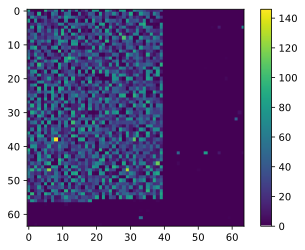

In [13]:
g = dpe.read(2)
plt.imshow(g * 1e6)
plt.colorbar()

In [31]:
print(g[38,8])

0.0001459758879113718


Calibrate all 12 ADCs on A0

In [17]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=4) )
    volts_set.append(volts)

5.00-

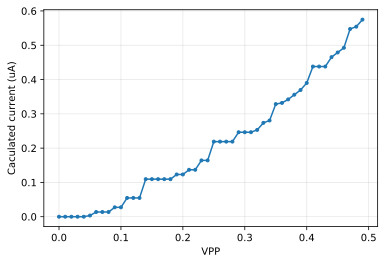

In [18]:
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

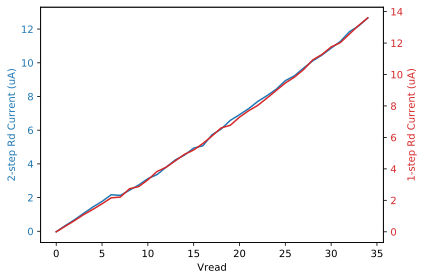

In [3]:
arr=2
rr=1
cc=1

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot([i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot([i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

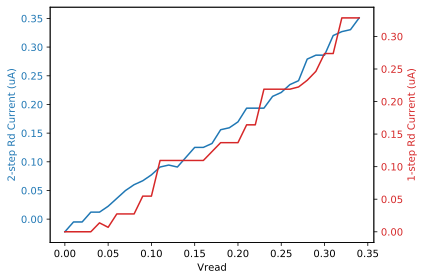

In [27]:
arr=2
rr=31
cc=0

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

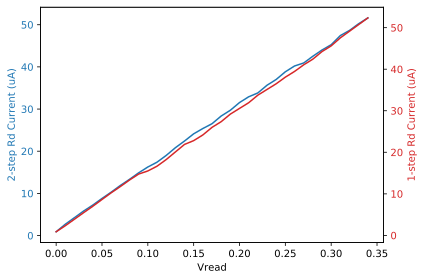

In [32]:
arr=2
rr=38
cc=8

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

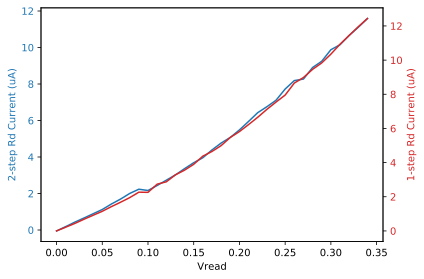

In [33]:
arr=2
rr=1
cc=1

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

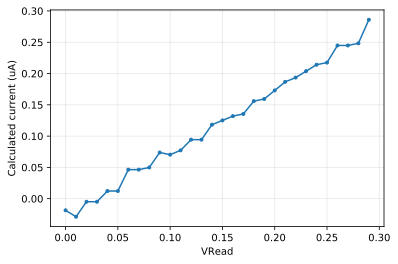

In [21]:
arr=2
rr=31
cc=0

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.3, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)

plt.plot(Vreads, [i* 1e6 for i in rdCurrs], '.-')
plt.xlabel('VRead')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
from bitstring import BitArray
import matplotlib.pyplot as plt
import dut_a0 as a0
from misc import *
drv = dut.drv

from lib_nn_dpe import NN_dpe
from lib_data import *
import time
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


[-16.96769924  -6.57786397  -6.25963033 -21.25901344 -15.58559587
 -31.62696164  -1.24566752 -35.71929698 -13.35733662 -53.59136278]
6


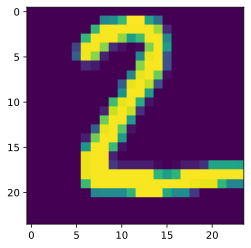

In [5]:
nn = NN_dpe(weights)

img_idx = 1

N_BIT = 8
image = test_images[img_idx]

plt.imshow(image[:,:,0])

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

vec_list = np.array(vec_list)
vec_list.shape

linear_factors_conv = [
       [ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]]

outputs_dpe_list = []
exp_out_list = []
soft_out_list = []

for vec in vec_list:
    inputs_dpe = []
    for v in vec.T:
        in_dpe = 0

        for i, el in enumerate(v):
            if el:
                in_dpe |= 0x1 << i
        inputs_dpe.append(in_dpe)

    # Hardware call
    outputs_dpe = a0.pic_dpe_batch(1, inputs_dpe, gain=-1, mode=1, col_en=[0x0000, 0x0000, 0x0000, 0x3fff])
    outputs_dpe = outputs_dpe[:,:14]

    for c in range(outputs_dpe.shape[1]):
        outputs_dpe[:,c] = outputs_dpe[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

    exp_out_list.append(outputs_dpe)
    soft_out_list.append( (nn.Gconv.T @ vec).T )

    outputs_dpe_list.append( outputs_dpe[:,::2] - outputs_dpe[:,1::2] )


result = np.zeros( outputs_dpe_list[0].shape )
for i in range(N_BIT):
    result += outputs_dpe_list[i] * (0x1<<i)

result = result / nn.Gratio / (2**N_BIT -1)

x = result.reshape(20,20,-1)

x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y)
print(y.argmax())

[-21.5454336    8.09553891 -35.83925685 -55.26789281  36.96550467
 -65.83232457 -25.15996982  14.5292833  -27.77900894 -22.11984788]


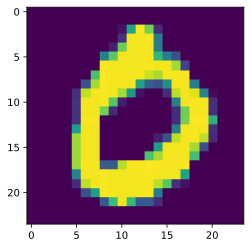

In [42]:
image = test_images[3]
plt.imshow(image[:,:,0])
print(y)

5.00-

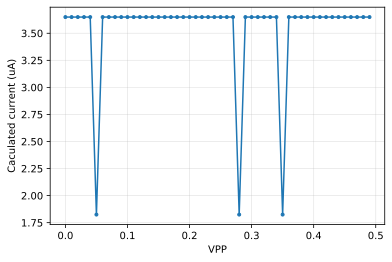

In [6]:
ar=2
r=0
c=61

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
# Vgates = [4, 3, 2, 1.5]
Vgates = [5]
Vref = 0.5

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_dpe_single_int(vread, Vgate, array=ar, row=r, col=c, gain=2, Vref = Vref) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [135]:
ar=2
r=31
c=0


Vread=0.1
Vgate=5

curr_list = []
# a0.read_single_int(Vread, Vgate, array=ar, row=r, col=c, gain=2) * 1e6
for Tsh in range(100):
    curr_list.append( a0.read_single_int(Vread, Vgate, array=ar, row=r, col=c, gain=4, Tsh=Tsh) )

Text(0, 0.5, 'Current @ 0.2 V')

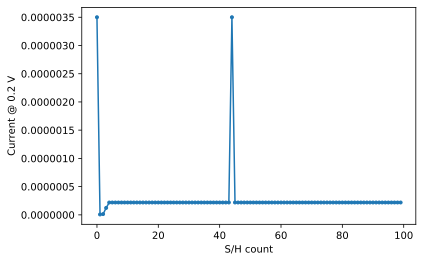

In [137]:
plt.plot(range(100), curr_list, '.-')
# plt.ylim(0,7e-5)
plt.xlabel('S/H count')
plt.ylabel('Current @ 0.2 V')
# for i in range(256):
#     print(f'{i} - {curr_list[i]}')

In [36]:
Vread=0.1
Vgate=5

curr_list = []
for Tsh in range(256):
    curr_list.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=2) )

(0, 7e-05)

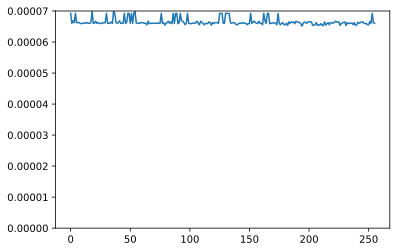

In [37]:
plt.plot(range(256), curr_list)
plt.ylim(0,7e-5)

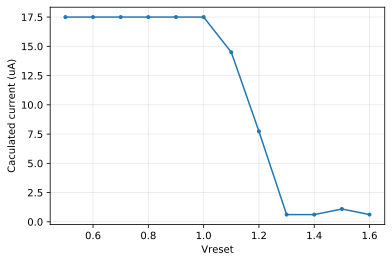

In [126]:
ar=2
r=8
c=4

Vreset = np.arange(0.5, 1.7, 0.1)
Vgate = 5
Vread = 0.2
volts = []
for Vr in Vreset:
    a0.reset_single_int(Vr, Vgate, array=ar, row=r, col=c)
    volts.append( a0.read_single_int(Vread, Vgate, array=ar, row=r, col=c, gain=3) )
    

plt.plot(Vreset, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('Vreset')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)
    

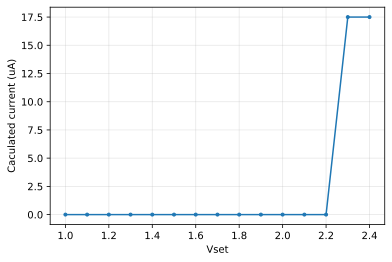

In [154]:
ar=2
r=46
c=25

Vset = np.arange(1, 2.5, 0.1)
Vgate = 1.5
Vread = 0.2
volts = []

for Vs in Vset:
    a0.set_single_int(Vs, Vgate, array=ar, row=r, col=c)
    volts.append( a0.read_single_int(Vread, Vgate, array=ar, row=r, col=c, gain=3) )
    

plt.plot(Vset, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('Vset')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)
    

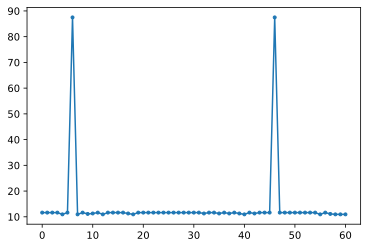

In [158]:
ar = 2
c = 25

Vread = 0.2
row = np.arange(0, 61, 1)
Vgate = 3
volts =[]

for r in row:
    volts.append( a0.read_dpe_single(Vread, Vgate, array=ar, row=r, col=c, gain=3) )

plt.plot(row, [a/0.2*1e6 for a in volts], '.-')


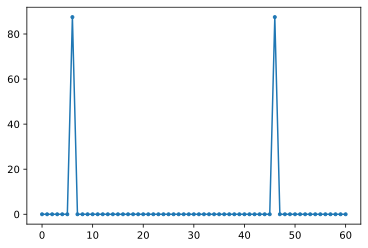

In [160]:
ar = 2
c = 25

Vread = 0.2
row = np.arange(0, 61, 1)
Vgate = 3
volts =[]

for r in row:
    volts.append( a0.read_single_int(Vread, Vgate, array=ar, row=r, col=c, gain=3) )

plt.plot(row, [a/0.2*1e6 for a in volts], '.-')

In [162]:
row = [1, 3]
index = []
for r in row:
    index.append(r)
    index.append(3)
print(index)

[1, 3, 3, 3]


In [312]:
ar = 2
c = 5

Vread = 0.1
Vgate = 5
data1 = a0.read_dpe_col_int(Vread, Vgate, array=ar, row=[0], col=c, gain=3)
# data1 = a0.read_dpe_col_int(Vread, Vgate, array=ar, row=[0], col=c, gain=2)/0.2*1e6
# data2 = a0.read_dpe_col_int(Vread, Vgate, array=ar, row=[46], col=c, gain=2)/0.2*1e6
# data3 = a0.read_dpe_col_int(Vread, Vgate, array=ar, row=[6, 46, 0, 2], col=c, gain=2)/0.2*1e6

print(data1)

1.67644183773216e-06


In [297]:
print(dut.data_generate_vector([0,0,0,1], [0, 0, 0, 1]))
print(dut.data_generate_sparse([0, 0]))

[0, 0, 1, 0, 32768, 0, 0, 0]
[0, 0, 1, 0, 32768, 0, 0, 0]


In [302]:
Vread = 0.1
Vgate = 5
row_vector = [0, 0, 0, 1]
volt = a0.read_dpe_int(Vread, Vgate, row_vector, array=2, gain=3, Vref=0.5)
print(volt)

[2.189638318670577e-06, 7.732160312805474e-06, 2.8054740957966762e-06, 1.0948191593352885e-06, 0.0, 1.7790811339198436e-06, 2.737047898338221e-06, 3.558162267839687e-06, 1.1752199413489736e-05, 4.516129032258065e-06, 4.379276637341154e-06, 5.20039100684262e-06, 5.131964809384164e-06, 2.189638318670577e-06, 1.3685239491691093e-07, 0.0, 0.0, 0.0, 5.901759530791789e-06, 1.531036168132942e-05, 6.089931573802542e-06, 1.366813294232649e-05, 0.0, 0.0, 0.0, 3.0107526881720425e-06, 0.0, 0.0, 3.626588465298143e-06, 4.926686217008797e-06, 5.6109481915933524e-06, 4.379276637341154e-06, 0.0, 5.884652981427175e-06, 7.834799608993157e-06, 5.474095796676442e-07, 0.0, 0.0, 1.0948191593352885e-06, 4.379276637341154e-06, 0.0, 0.0, 2.189638318670577e-06, 2.189638318670577e-06, 2.189638318670577e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8739002932551316e-06, 2.4633431085043987e-06, 3.9687194525904206e-06, 8.46774193548387e-06, 1.0948191593352885e-06, 0.0, 1.202590420332356e-05, 6.637341153470185e-06, 6.8426197458455

In [192]:
for b in range(0, 32, 2):
    print(b)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


In [291]:
[fifo_en, channel] = dut.which_fifo([2, 63])
print(fifo_en, channel)

7 7


In [321]:
Vread = 0.2
Vgate = 5
array = 2
Gmap = np.zeros((64,64))
for r in range(64):
    print(r)
    for c in range(64):
        Gmap[r, c] = a0.read_dpe_single_int(Vread, Vgate, array=array, row=r, col=c, gain=3)/0.2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


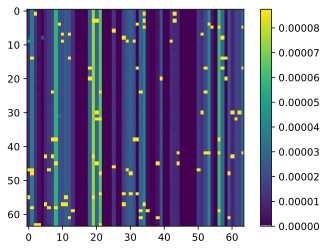

In [324]:
plt.imshow(Gmap)
plt.colorbar()

In [31]:
Vread = 0.2
Vgate =5
Gmap = np.zeros((64, 64))
for a in range(4):
    for b in range(16):
        row_vector = [0, 0, 0, 0]
        row_vector[3-a] = 0b1 << b
        Gmap[16*a+b] = a0.read_dpe_int(Vread, Vgate, row_vector, array=2, gain=3, Vref=0.5)


AttributeError: 'NoneType' object has no attribute 'write'

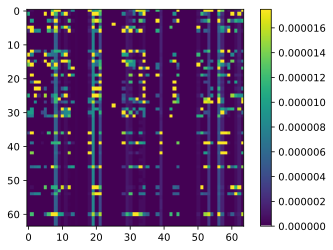

In [40]:
plt.imshow(Gmap)
plt.colorbar()

In [ ]:
Vread = 0.2
Vgate = 5
array = 2
Gmap = np.zeros((64,64))
for r in range(64):
    print(r, end='-')
    for c in range(64):
        Gmap[r, c] = a0.read_single_int(Vread, Vgate, array=array, row=r, col=c, gain=3)/0.2

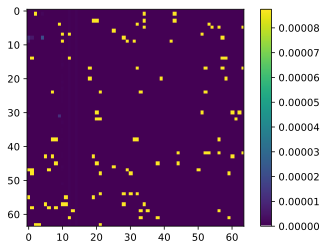

In [8]:
plt.imshow(Gmap)
plt.colorbar()

In [49]:
a0.read_single_int(0.2, 5, array=2, row=1, col=2, gain=2)

['0x0', '0x0', '0x100', '0x0', '0x4000', '0x0', '0x0', '0x0']
13ff
13ff
13ff
13ff
13ff
13ff
13ff
1068
13ff
13ff
13ff
13ff
13ff
13ff
13ff
13ff
fifo_0, ch=6


0.00011666666666666667

In [66]:
_gain_table = [
    '0b1111100001',
    '0b1111100010',
    '0b1101000100',
    '0b1100001000',
    '0b1100010000',
    ]

VREF_TIA = 0.5
VREF_LO = 0.5

Vread = 0.2
Tsh = 0x0c

dut.scan_control(scan_ctrl_bits=bytes([0x10, 0x02, 0x0c, 0x10,
                                       Tsh, 0x01, 0x02]))

dut.scan_tia( BitArray(_gain_table[2]*96).bytes )


assert VREF_TIA - Vread > -0.2 and VREF_TIA - Vread <= 1

dut.dac_set('PLANE_VPP', VREF_TIA - Vread)
dut.dac_set('P_VREF_TIA', VREF_TIA)
dut.dac_set('P_TVDD', Vgate)

dut.pads_defaults()

dut.reset_dpe()

In [88]:
# dut.reset_dpe()

drv.ser.write(b'401,2,1,2\0')
value = drv.ser.read(2)
value = struct.unpack('<H', value)
value

(3035,)

In [161]:
drv.ser.flushInput()

PIC single read!

In [164]:
a0.pic_read_single(2,1,2, gain=2)

0.00011301726946888238

In [81]:
gain=2
f"{gain},ahha\0".encode()

b'2,ahha\x00'

In [96]:
dut.py_logic_analyzer()

1 	PWR_GOOD
1 	NRESET_FULL_CHIP
1 	NRESET_DPE_ENGINE
0 	ARRAY_EN<0>
0 	ARRAY_EN<1>
1 	ARRAY_EN<2>
0 	NFORCE_SAFE0
0 	NFORCE_SAFE1
1 	NFORCE_SAFE2
0 	ADC_SEL_EXT
0 	DPE_EXT_OVERRIDE_EN
0 	DPE_EXT_SH
1 	ADC_DONE
0 	ADC_FIFO_ADVANCE
1 	ADC_FIFO_EN<0>
1 	ADC_FIFO_EN<1>
1 	ADC_FIFO_EN<2>
0 	ADC_FIFO_EN<3>


In [19]:
from dut_func import *

Test PIC download_fofo()

In [ ]:
addr_fifo = 0

reset_dpe()
drv.gpio_array_en_write(0b111)
drv.gpio_nforce_safe_write(0b111)

drv.gpio_pin_set(*PIC_PINS['ADC_SEL_EXTERNAL'])
# time.sleep(1e-6)       # delay(t_en_overide_sh), min = 0CK
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_OVERRIDE_EN'])
time.sleep(1e-6)        # delay(t_fire_sh), min = 3CK
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])


dac_set('P_ADC_EXT_TEST_IN', 1)

drv.gpio_pin_reset(*PIC_PINS['DPE_EXT_SH'])
reset_dpe()
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

data_fifo = download_fifo(addr_fifo)
[hex(d) for d in data_fifo]

In [18]:
addr_fifo = 0

reset_dpe()
drv.gpio_array_en_write(0b111)
drv.gpio_nforce_safe_write(0b111)

drv.gpio_pin_set(*PIC_PINS['ADC_SEL_EXTERNAL'])
# time.sleep(1e-6)       # delay(t_en_overide_sh), min = 0CK
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_OVERRIDE_EN'])
time.sleep(1e-6)        # delay(t_fire_sh), min = 3CK
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])


dac_set('P_ADC_EXT_TEST_IN', 1)

drv.gpio_pin_reset(*PIC_PINS['DPE_EXT_SH'])
reset_dpe()
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

drv.ser.write(b'301,0')
drv.ser.flushInput()
value = drv.ser.read(2*16)
value = drv.struct.unpack('<' +'H'*16, value)

[hex(d) for d in value]

NameError: name 'reset_dpe' is not defined

Test batch read!

In [215]:
a0.pic_read_config(gain=2)

In [216]:
drv.ser.flushInput()
drv.ser.write(f'402'.encode() )
data = []

r=0
while True:
    value = drv.ser.read(2 * 256)
    if len(value) == 0:
        print(f'Wait for data r={r}')
        continue
    value = struct.unpack('<' +'H'*256, value)
    data.append(value)
    
    r += 1
    if r>=48:
        break;


Wait for data r=0
Wait for data r=0


In [217]:
npdata = np.array(data)

In [218]:
npdata.shape

(48, 256)

In [219]:
npdata.reshape((3,64,64))

array([[[2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        ...,
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048]],

       [[2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        ...,
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [3071, 2048, 2048, ..., 2048, 2048, 2048]],

       [[2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 3031, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        ...,
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 2048, ..., 2048, 2048, 2048],
        [2048, 2048, 3071, ..., 2048, 2048, 2048]]])

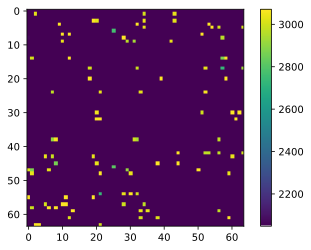

In [220]:
plt.imshow(npdata.reshape(3,64,64)[2])
plt.colorbar()

In [141]:
drv.ser.flushInput()
drv.ser.write(f'402'.encode() )
value = drv.ser.read(2 * 256 * 48)
len(value)

11776

In [140]:
value = struct.unpack('<' +'H'*256*48, value)

error: unpack requires a buffer of 24576 bytes

In [243]:
data = a0.pic_read_batch(gain=3, Vread=0.2)

Wait for data r=0
Wait for data r=0


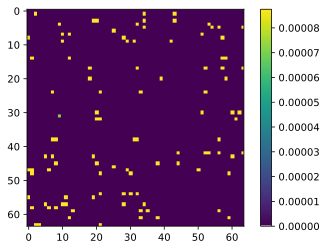

In [30]:
plt.imshow(data[2] / 0.2)
plt.colorbar()

In [6]:
dpe

NameError: name 'dpe' is not defined

In [ ]:
nn = NN_dpe(weights)

img_idx = 1

N_BIT = 8
image = test_images[img_idx]

plt.imshow(image[:,:,0])

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

vec_list = np.array(vec_list)
vec_list.shape

linear_factors_conv = [
       [ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]]

outputs_dpe_list = []
exp_out_list = []
soft_out_list = []

for vec in vec_list:
    inputs_dpe = []
    for v in vec.T:
        in_dpe = 0

        for i, el in enumerate(v):
            if el:
                in_dpe |= 0x1 << i
        inputs_dpe.append(in_dpe)

    # Hardware call
    outputs_dpe = a0.pic_dpe_batch(1, inputs_dpe, gain=-1, mode=1, col_en=[0x0000, 0x0000, 0x0000, 0x3fff])
    outputs_dpe = outputs_dpe[:,:14]

    for c in range(outputs_dpe.shape[1]):
        outputs_dpe[:,c] = outputs_dpe[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

    exp_out_list.append(outputs_dpe)
    soft_out_list.append( (nn.Gconv.T @ vec).T )

    outputs_dpe_list.append( outputs_dpe[:,::2] - outputs_dpe[:,1::2] )


result = np.zeros( outputs_dpe_list[0].shape )
for i in range(N_BIT):
    result += outputs_dpe_list[i] * (0x1<<i)

result = result / nn.Gratio / (2**N_BIT -1)

x = result.reshape(20,20,-1)

x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y)
print(y.argmax())